In [1]:
import os
from datetime import datetime
import pickle

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from prophet.utilities import regressor_coefficients

from elbonia_modeling import create_forecast

load_dotenv()


c:\Users\keita\anaconda3\envs\nuovo_ambiente\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


True

In [2]:
df = pd.read_csv('df_inno_elbo.csv', sep=',')
df = df.fillna(0)

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

<Axes: xlabel='Date'>

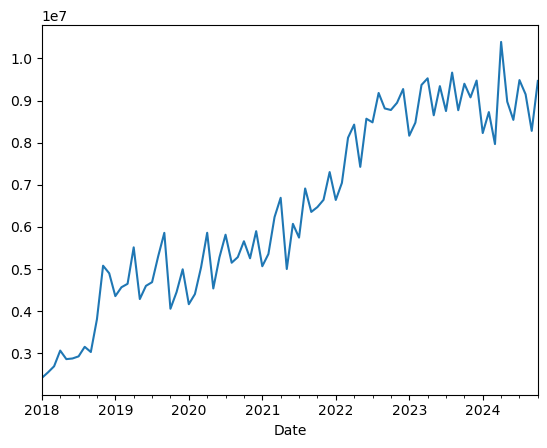

In [4]:
df.set_index('Date')['Ex-factory volumes'].plot()

This time series is clearly not stationary, does not have a strong seasonality but there is an upwards trend

## Feature selection

In [5]:
regressors = [col for col in df.columns if col not in ['Date', 'Ex-factory volumes']]

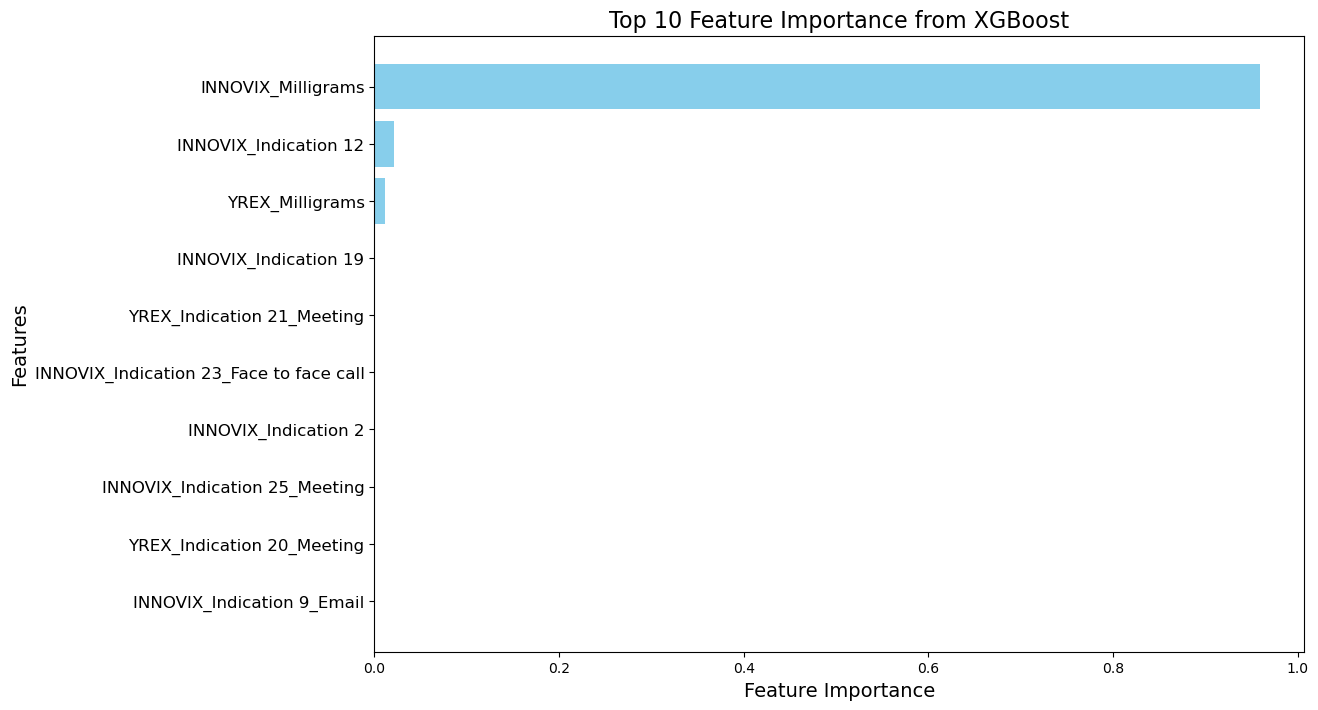

Selected Features for Prophet: ['INNOVIX_Milligrams', 'INNOVIX_Indication 12', 'YREX_Milligrams', 'INNOVIX_Indication 19', 'YREX_Indication 21_Meeting', 'INNOVIX_Indication 23_Face to face call', 'INNOVIX_Indication 2', 'INNOVIX_Indication 25_Meeting', 'YREX_Indication 20_Meeting', 'INNOVIX_Indication 9_Email']


In [6]:
X = df[regressors]
y = df['Ex-factory volumes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost
xgb_model = XGBRegressor(random_state=42, n_estimators=100, max_depth=3)
xgb_model.fit(X_train, y_train)

# Feature importance
feature_importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': regressors, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

top_features = 10
top_importance_df = importance_df.head(top_features)

plt.figure(figsize=(12, 8))
plt.barh(top_importance_df['Feature'], top_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top 10 Feature Importance from XGBoost', fontsize=16)

plt.tick_params(axis='y', labelsize=12)
plt.gca().invert_yaxis()
plt.show()

selected_features = importance_df['Feature'].head(10).tolist()

print(f"Selected Features for Prophet: {selected_features}")

**Why Remove Collinearity in Time Series Forecasting?**  

- **Improves model stability**: Prevents unstable or unreliable coefficients.  
- **Enhances prediction accuracy**: Reduces overfitting and improves generalization.  
- **Increases interpretability**: Clarifies the impact of each regressor.  
- **Avoids redundancy**: Removes unnecessary or duplicate information.  
- **Boosts efficiency**: Simplifies the model and reduces computational complexity.  

Filtered Features for Prophet: ['INNOVIX_Milligrams', 'INNOVIX_Indication 12', 'INNOVIX_Indication 19', 'YREX_Indication 21_Meeting', 'INNOVIX_Indication 23_Face to face call', 'INNOVIX_Indication 2', 'INNOVIX_Indication 25_Meeting', 'YREX_Indication 20_Meeting', 'INNOVIX_Indication 9_Email']
Removed Correlated Features: {'YREX_Milligrams'}


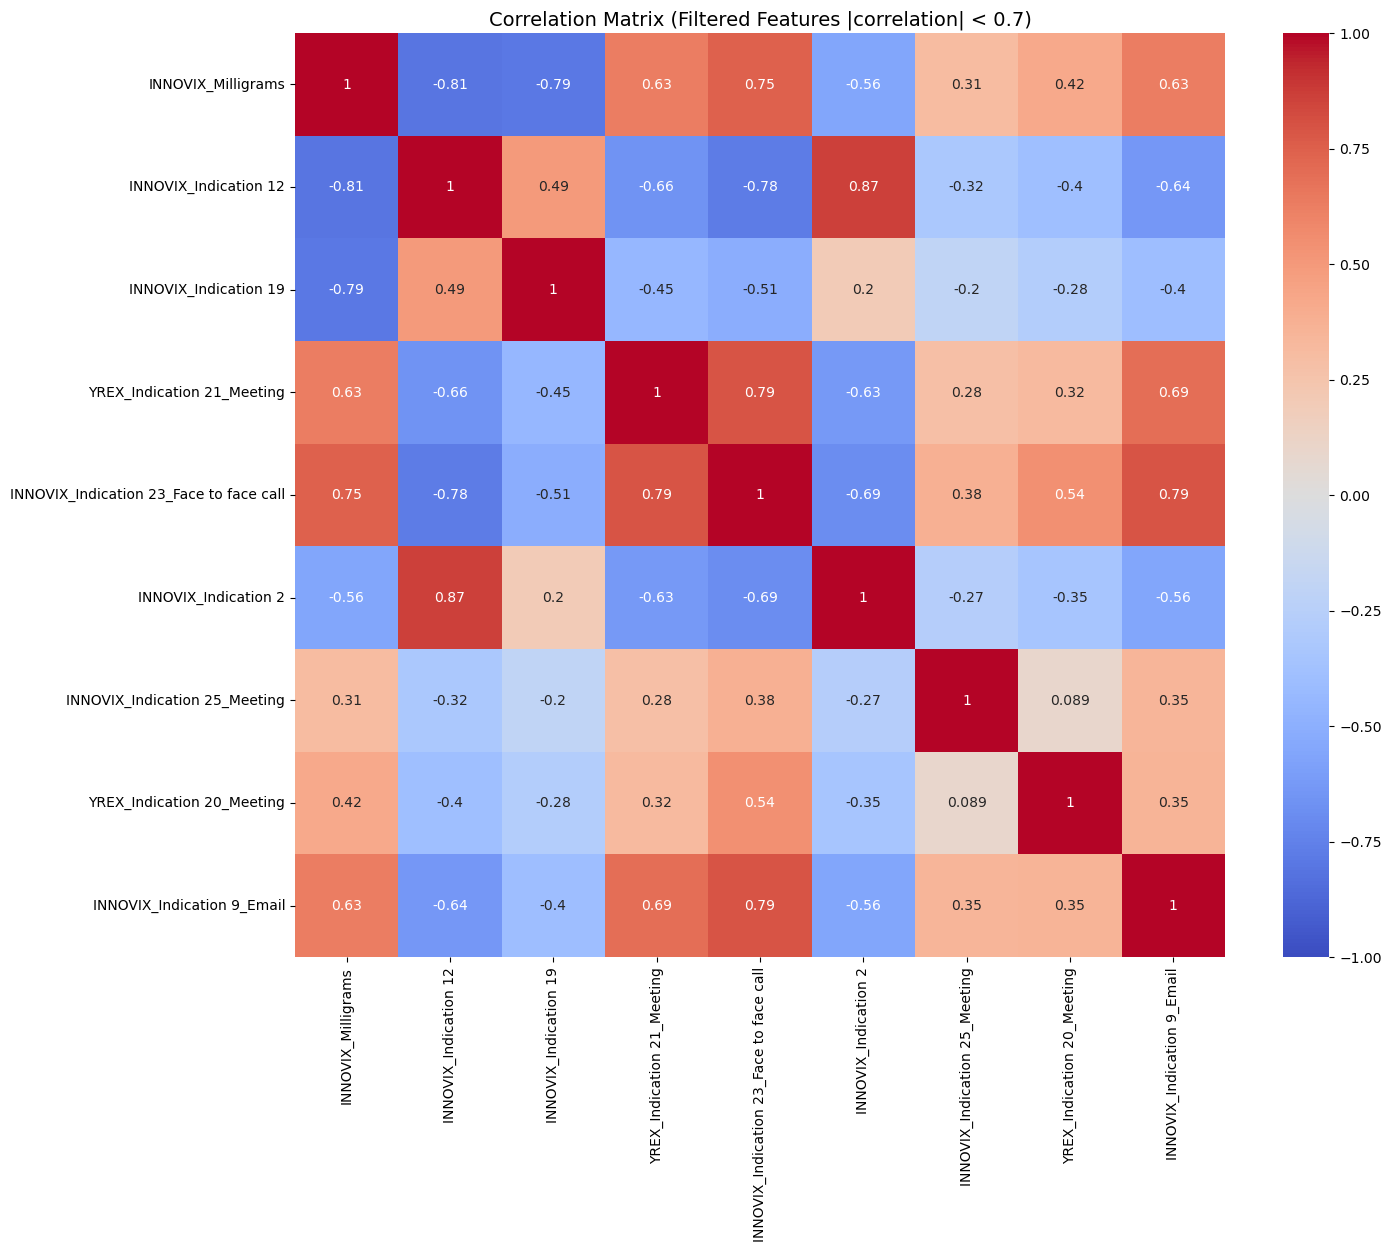

In [8]:
# Correlation matrix for features
corr_matrix = df[selected_features].corr()

correlated_features = set()
threshold = 0.9

target_corr = df[selected_features].corrwith(df['Ex-factory volumes'])

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            col_i = corr_matrix.columns[i]
            col_j = corr_matrix.columns[j]

            # Delete the feature less important with the target
            if abs(target_corr[col_i]) > abs(target_corr[col_j]):
                correlated_features.add(col_j)
            else:
                correlated_features.add(col_i)

filtered_features = [col for col in selected_features if col not in correlated_features]

print(f"Filtered Features for Prophet: {filtered_features}")
print(f"Removed Correlated Features: {correlated_features}")

filtered_corr = df[filtered_features].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title('Correlation Matrix (Filtered Features |correlation| < 0.7)', fontsize=14)
plt.show()

### COEFFICIENTS
- Positive Impact:
Regressors like **INNOVIX_Indication 25_Email**, **YREX_Indication 10_Email**, and **YREX_Indication 24_Email** contribute positively to the forecast. This means that as their values increase, the predicted outcome also increases.
These variables play a supportive role in boosting the target variable.

- Negative Impact:
Regressors such as **INNOVIX_Indication 14_Email**, **INNOVIX_Indication 14_Meeting**, and **YREX_Indication 14_Email** have a negative effect on the forecast. As their values rise, they decrease the forecasted outcome.
These variables might represent factors that detract from the target variable.

- Magnitude of Impact:
Regressors like **INNOVIX_Indication 16** have an extraordinarily large positive effect, indicating that even small changes in their values can significantly influence the forecast.
Conversely, some regressors, such as **INNOVIX_Indication 11**, have an extremely minimal impact, making their contribution negligible.

In [9]:
#Reload the model
with open('prophet_model_elbonia.pkl', 'rb') as f:
    m = pickle.load(f)

coefficients = regressor_coefficients(m)
coefficients


,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,INNOVIX_Indication 12_Email,additive,80.148675,7.172150e+02,7.172150e+02,7.172150e+02
1,INNOVIX_Indication 14_Email,additive,42.122550,-3.516461e+02,-3.516461e+02,-3.516461e+02
2,INNOVIX_Indication 14_Meeting,additive,19.876529,-9.022287e+02,-9.022287e+02,-9.022287e+02
3,INNOVIX_Indication 1_Email,additive,71.062803,-3.243421e+01,-3.243421e+01,-3.243421e+01
4,INNOVIX_Indication 25_Email,additive,240.921908,2.318261e+02,2.318261e+02,2.318261e+02
5,INNOVIX_Indication 25_Meeting,additive,123.162478,1.093403e+02,1.093403e+02,1.093403e+02
6,INNOVIX_Indication 2_Meeting,additive,104.507256,-5.749865e+02,-5.749865e+02,-5.749865e+02
7,YREX_Indication 10_Email,additive,86.830194,1.933742e+02,1.933742e+02,1.933742e+02
8,YREX_Indication 10_Face to face call,additive,186.813029,-3.979292e+02,-3.979292e+02,-3.979292e+02
9,YREX_Indication 12_Meeting,additive,228.953835,8.139755e+01,8.139755e+01,8.139755e+01
